In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import geopandas as gpd

import extracting_points_from_polygons as pp

# Using Skicit-learn to split data into training and testing sets 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import confusion_matrix

import pystac_client 
import planetary_computer as pc

import iceplant_detection_functionsCopy1 as ipf

In [29]:
def iceplant_counts(df):
    return df.filter(items=['iceplant']).groupby(['iceplant']).size().reset_index(name='count')


# def aoi_to_samples(root,aoi,year):
#     # root for all polygons collected on naip scenes
#     fp = os.path.join(root, 
#                       aoi+'_polygons', 
#                       aoi+'_polygons_'+str(year), 
#                       aoi+'_polygons_'+str(year)+'.shp')
#     polys = gpd.read_file(fp)
#     itemid = polys['naip_id'][0]
#     points = pp.naip_sample_no_warnings(polys,itemid)
#     return points

In [30]:
root = '/home/jovyan/msai4earth-esa/iceplant_detection'
aois = gpd.read_file(os.path.join(root,'areas_of_interest','areas_of_interest.shp'))
cp = aois.iloc[0]  # Campus Lagoon aoi

In [4]:
aoi = 'campus_lagoon'
year = 2018 
fp = pp.path_to_polygons(aoi,year)
polys = gpd.read_file(fp)
#polys_raw

## Sampling 20% of pixels

In [5]:
sample1 = pp.naip_sample_proportion_no_warnings(polys, polys.naip_id[0], 0.2)

In [6]:
ipf.iceplant_proportions(sample1.iceplant)

no-iceplant:iceplant ratio     62.2 :1
          counts  percentage
iceplant                    
0         100065       98.42
1           1609        1.58



### Random forest

Text(0.5, 1.0, 'point samples by polygon id --- 0.2 samples')

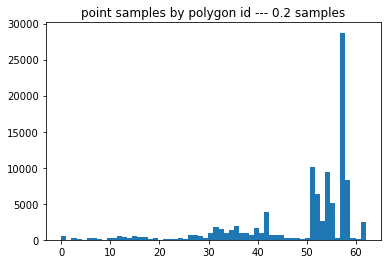

In [7]:
plt.hist(sample1.polygon_id,bins=60)
plt.title('point samples by polygon id --- 0.2 samples')

In [8]:
counts = np.unique(sample1.polygon_id.to_numpy(), return_counts=True)
counts = pd.DataFrame({'poly_id':counts[0], 'count':counts[1]}).sort_values(by=['count'], ascending=False)
counts.head(10)

,poly_id,count
54,57,28729
48,51,10066
51,54,9412
55,58,8334
49,52,6398
52,55,5071
39,42,3827
50,53,2667
59,62,2109
33,36,1852


In [9]:
counts.tail(5)

,poly_id,count
4,4,96
0,0,59
23,25,51
5,5,39
2,2,32


In [10]:
sample1.drop(['geometry','x','y','year','month','day','naip_id','polygon_id'],axis=1, inplace=True)
sample1 = sample1[['r','g','b','nir','iceplant']]
#sample1

In [11]:
# Labels & Features
y = np.array(sample1['iceplant'])
X = np.array(sample1.drop('iceplant', axis = 1))
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state = 42)

rfc = RandomForestClassifier(n_estimators = 100, random_state = 42)
rfc.fit(train_X,train_y)

RandomForestClassifier(random_state=42)

In [12]:
predictions = rfc.predict(test_X)
ipf.print_threshold_metrics(test_y,predictions)


true negatives: 29934     false positives: 70
false negatives: 99     true positives: 400

sensitivity (TP/P): 80.16 %
specificity (TN/N): 99.77 %
G-mean:  0.89

precision (TP/(TP+FP)): 85.11 %

MCC:  0.8231617401894974

F1-measure:  0.82559
F0.5-measure (min false positives):  0.84069
F2-measure (min false negatives)  :  0.81103

accuracy: 99.45 %



/home/jovyan/msai4earth-esa/iceplant_detection/data_sampling/iceplant_detection_functionsCopy1.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vegetation.drop(labels=['ndvi'],axis=1, inplace=True)


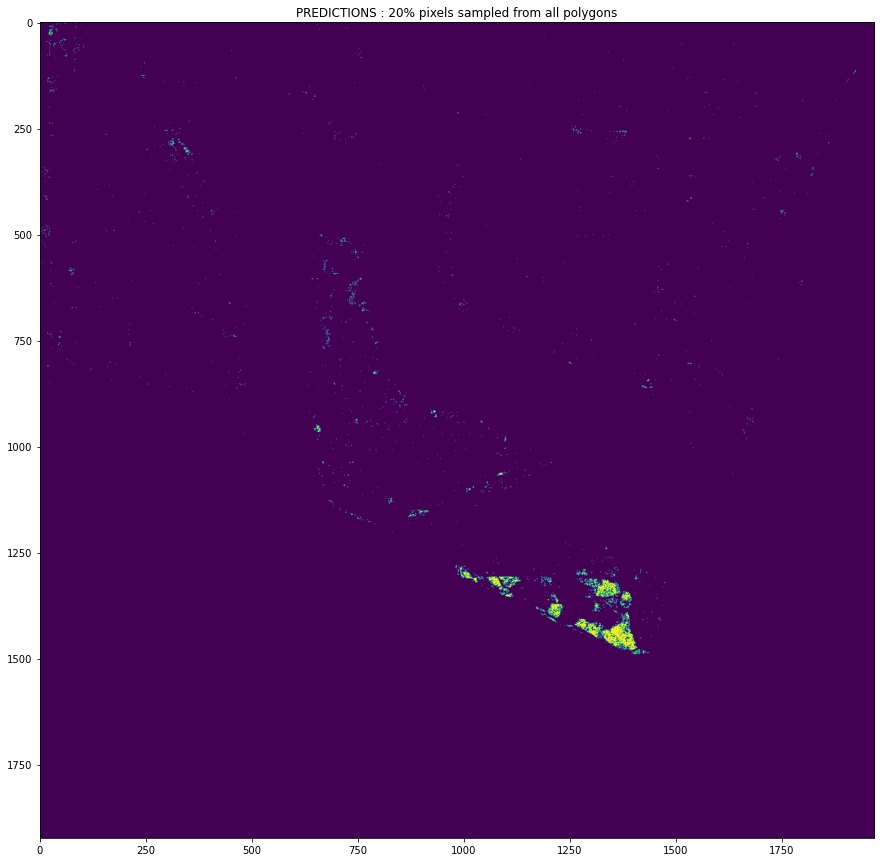

In [13]:
reconstructed = ipf.mask_ndvi_and_predict(cp.itemid, cp.geometry, rfc)

fig, ax = plt.subplots(figsize=(15, 15))
plt.title("PREDICTIONS : 20% pixels sampled from all polygons")
ax.imshow(reconstructed)
plt.show()

## Sampling 0.8 iceplant, 0.2 non-iceplant

In [31]:
polys_iceplant = polys.loc[polys.iceplant==1]
polys_iceplant.reset_index(inplace=True, drop=True)

polys_noniceplant = polys.loc[polys.iceplant==0]
polys_noniceplant.reset_index(inplace=True, drop=True)

In [15]:
pts_iceplant = pp.naip_sample_proportion_no_warnings(polys_iceplant, polys.naip_id[0], 0.8)
pts_noniceplant = pp.naip_sample_proportion_no_warnings(polys_noniceplant, polys.naip_id[0], 0.2)

In [16]:
sample2 = pd.concat([pts_iceplant, pts_noniceplant])
ipf.iceplant_proportions(sample2.iceplant)

no-iceplant:iceplant ratio     15.5 :1
          counts  percentage
iceplant                    
0         100065       93.95
1           6449        6.05



In [17]:
sample2.drop(['geometry','x','y','year','month','day','naip_id','polygon_id'],axis=1, inplace=True)
sample2 = sample2[['r','g','b','nir','iceplant']]

In [18]:
# Labels & Features
y = np.array(sample2['iceplant'])
X = np.array(sample2.drop('iceplant', axis = 1))
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state = 42)

rfc = RandomForestClassifier(n_estimators = 100, random_state = 42)
rfc.fit(train_X,train_y)

RandomForestClassifier(random_state=42)

In [19]:
predictions = rfc.predict(test_X)
ipf.print_threshold_metrics(test_y, predictions)


true negatives: 29889     false positives: 166
false negatives: 141     true positives: 1759

sensitivity (TP/P): 92.58 %
specificity (TN/N): 99.45 %
G-mean:  0.96

precision (TP/(TP+FP)): 91.38 %

MCC:  0.914651468940732

F1-measure:  0.91974
F0.5-measure (min false positives):  0.91615
F2-measure (min false negatives)  :  0.92336

accuracy: 99.04 %



/home/jovyan/msai4earth-esa/iceplant_detection/data_sampling/iceplant_detection_functionsCopy1.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vegetation.drop(labels=['ndvi'],axis=1, inplace=True)


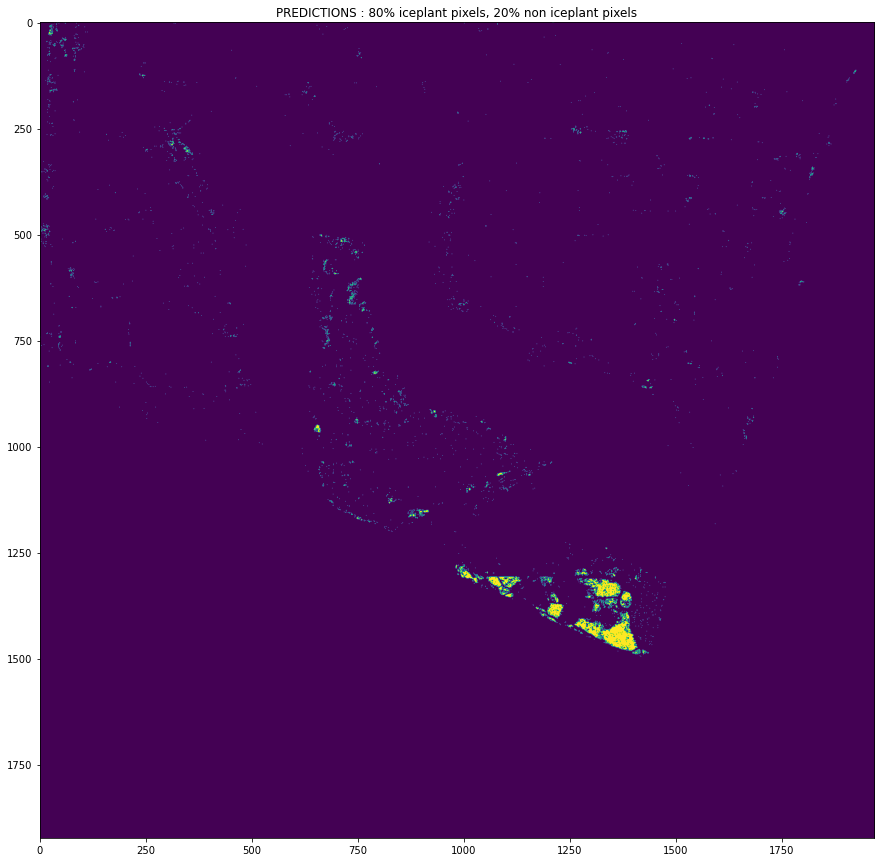

In [20]:
reconstructed = ipf.mask_ndvi_and_predict(cp.itemid, cp.geometry, rfc)

fig, ax = plt.subplots(figsize=(15, 15))
plt.title("PREDICTIONS : 80% iceplant pixels, 20% non iceplant pixels")
ax.imshow(reconstructed)
plt.show()

## Custom sampling
Sampling 250 pts from each non-iceplant polygon and 80% of all pixels in the iceplant polygons

In [116]:
pts_non250 = pp.naip_sample_n_no_warnings(polys_noniceplant, polys.naip_id[0], 250)

In [117]:
sample3 = pd.concat([pts_iceplant, pts_non250])
ipf.iceplant_proportions(sample3.iceplant)

no-iceplant:iceplant ratio     2.0 :1
          counts  percentage
iceplant                    
0          12750       66.41
1           6449       33.59



In [118]:
sample3.drop(['geometry','x','y','year','month','day','naip_id','polygon_id'],axis=1, inplace=True)
sample3 = sample3[['r','g','b','nir','iceplant']]

In [119]:
# Labels & Features
y = np.array(sample3['iceplant'])
X = np.array(sample3.drop('iceplant', axis = 1))
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state = 42)

rfc = RandomForestClassifier(n_estimators = 100, random_state = 42)
rfc.fit(train_X,train_y)

RandomForestClassifier(random_state=42)

In [120]:
predictions = rfc.predict(test_X)
ipf.print_threshold_metrics(test_y,predictions)


true negatives: 3781     false positives: 59
false negatives: 48     true positives: 1872

sensitivity (TP/P): 97.5 %
specificity (TN/N): 98.46 %
G-mean:  0.98

precision (TP/(TP+FP)): 96.94 %

MCC:  0.9582717257976391

F1-measure:  0.97222
F0.5-measure (min false positives):  0.97055
F2-measure (min false negatives)  :  0.97388

accuracy: 98.14 %



/home/jovyan/msai4earth-esa/iceplant_detection/data_sampling/iceplant_detection_functionsCopy1.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vegetation.drop(labels=['ndvi'],axis=1, inplace=True)


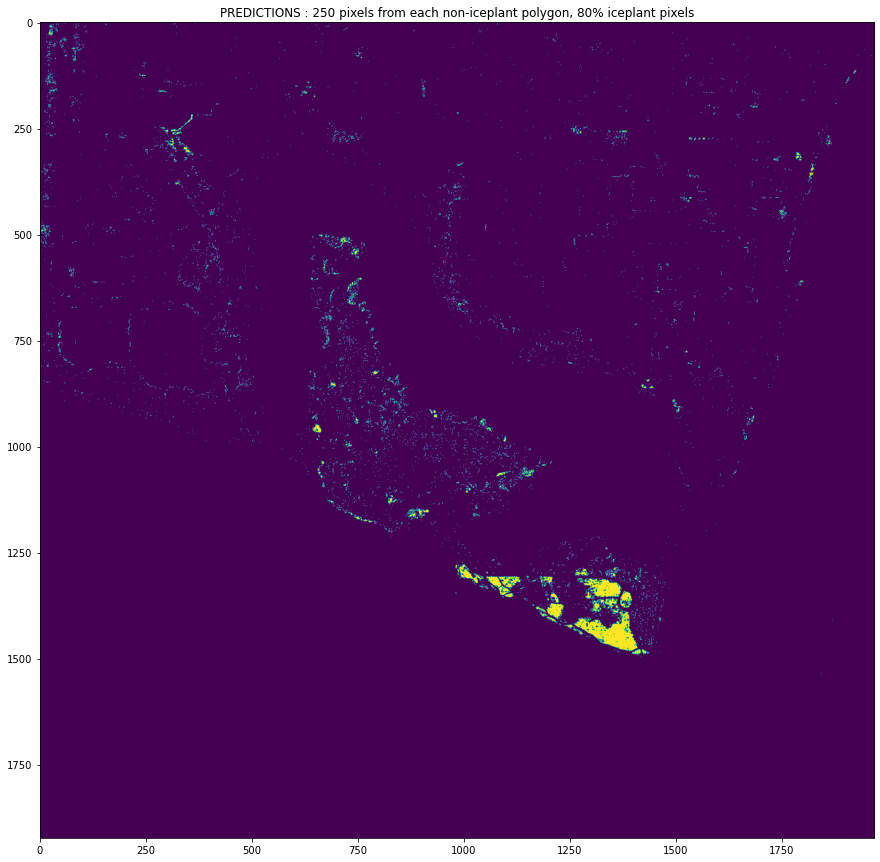

In [121]:
reconstructed = ipf.mask_ndvi_and_predict(cp.itemid, cp.geometry, rfc)

fig, ax = plt.subplots(figsize=(15, 15))
plt.title("PREDICTIONS : 250 pixels from each non-iceplant polygon, 80% iceplant pixels")
ax.imshow(reconstructed)
plt.show()

In [ ]:
# df = pd.concat([pts_ice,pts_nonice])
# df.drop(['geometry','x','y','naip_id','polygon_id','month','day','year'], axis=1, inplace=True)
# df['ndvi'] = (df.nir.astype('int16') - df.r.astype('int16'))/(df.nir.astype('int16') + df.r.astype('int16'))
# df = df[['r','g','b','nir','ndvi','iceplant']]
# df

## Decreasing proportions

In [76]:
itemid = pp.get_item_from_id(polys.naip_id[0])
naip = pp.get_raster_from_item(itemid)

pixel_size = naip.res[0]*naip.res[1]

polys_noniceplant['pixels'] = polys_noniceplant.to_crs(naip.crs).geometry.apply(lambda p: int((p.area/pixel_size)))

/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [82]:
polys_noniceplant = polys_noniceplant.sort_values(by=['pixels'], ascending=False).reset_index(drop=True)
polys_noniceplant

,id,iceplant,year,month,day,naip_id,geometry,pixels
0,57,0,2018,7,22,ca_m_3411934_sw_11_060_20180722_20190209,"POLYGON ((-119.86389 34.43909, -119.85936 34.4...",143645
1,51,0,2018,7,22,ca_m_3411934_sw_11_060_20180722_20190209,"POLYGON ((-119.82398 34.42103, -119.82306 34.4...",50332
2,54,0,2018,7,22,ca_m_3411934_sw_11_060_20180722_20190209,"POLYGON ((-119.82571 34.43254, -119.82334 34.4...",47062
3,58,0,2018,7,22,ca_m_3411934_sw_11_060_20180722_20190209,"POLYGON ((-119.86445 34.43510, -119.86184 34.4...",41672
4,52,0,2018,7,22,ca_m_3411934_sw_11_060_20180722_20190209,"POLYGON ((-119.82007 34.42278, -119.81806 34.4...",31994
5,55,0,2018,7,22,ca_m_3411934_sw_11_060_20180722_20190209,"POLYGON ((-119.82909 34.43965, -119.82726 34.4...",25358
6,42,0,2018,7,22,ca_m_3411934_sw_11_060_20180722_20190209,"POLYGON ((-119.85903 34.41934, -119.85813 34.4...",19137
7,53,0,2018,7,22,ca_m_3411934_sw_11_060_20180722_20190209,"POLYGON ((-119.82175 34.41844, -119.82143 34.4...",13335
8,62,0,2018,7,22,ca_m_3411934_sw_11_060_20180722_20190209,"POLYGON ((-119.87620 34.41207, -119.87624 34.4...",10549
9,36,0,2018,7,22,ca_m_3411934_sw_11_060_20180722_20190209,"POLYGON ((-119.87673 34.41801, -119.87653 34.4...",9261


In [83]:
n1 = polys_noniceplant.pixels[pixels.shape[0]-1]
nN = polys_noniceplant.pixels[0]
print(n1, nN)

256 143645


In [84]:
alpha = 0.8
diff = 1000
beta = (diff + alpha*n1)/nN
step = (alpha - beta)/pixels.shape[0]
proportions = np.arange(beta,alpha,step)

In [85]:
proportions

array([0.00838734, 0.02390916, 0.03943098, 0.05495279, 0.07047461,
       0.08599643, 0.10151824, 0.11704006, 0.13256188, 0.14808369,
       0.16360551, 0.17912733, 0.19464915, 0.21017096, 0.22569278,
       0.2412146 , 0.25673641, 0.27225823, 0.28778005, 0.30330186,
       0.31882368, 0.3343455 , 0.34986731, 0.36538913, 0.38091095,
       0.39643276, 0.41195458, 0.4274764 , 0.44299821, 0.45852003,
       0.47404185, 0.48956366, 0.50508548, 0.5206073 , 0.53612911,
       0.55165093, 0.56717275, 0.58269456, 0.59821638, 0.6137382 ,
       0.62926002, 0.64478183, 0.66030365, 0.67582547, 0.69134728,
       0.7068691 , 0.72239092, 0.73791273, 0.75343455, 0.76895637,
       0.78447818])

In [92]:
num_random_pts = proportions * polys_noniceplant.pixels.to_numpy()
num_random_pts = num_random_pts.astype('int16')
num_random_pts

array([1204, 1203, 1855, 2289, 2254, 2180, 1942, 1560, 1398, 1371, 1410,
       1454, 1414, 1495, 1095, 1168, 1219, 1221, 1269, 1104, 1057, 1088,
       1079, 1127, 1172, 1011, 1049, 1010,  968,  942,  786,  802,  752,
        754,  763,  730,  727,  720,  719,  721,  656,  667,  654,  644,
        600,  588,  526,  509,  458,  418,  200], dtype=int16)

In [94]:
import warnings

In [107]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ptsnon_descending = pp.sample_naip(polys_noniceplant.to_crs(naip.crs), num_random_pts, naip, itemid)

Text(0.5, 1.0, 'point samples by polygon id --- 0.2 samples')

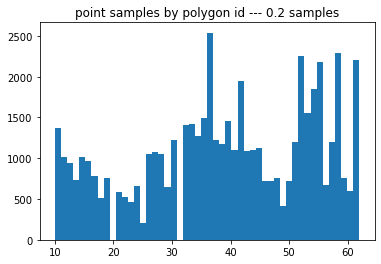

In [99]:
plt.hist(ptsnon_descending.polygon_id,bins=50)
plt.title('point samples by polygon id --- 0.2 samples')

In [105]:
ptsnon_descending.shape

(54002, 13)

In [108]:
sample4 = pd.concat([pts_iceplant, ptsnon_descending])
ipf.iceplant_proportions(sample4.iceplant)

no-iceplant:iceplant ratio     8.4 :1
          counts  percentage
iceplant                    
0          54002       89.33
1           6449       10.67



In [110]:
sample4.drop(['geometry','x','y','year','month','day','naip_id','polygon_id'],axis=1, inplace=True)
sample4 = sample4[['r','g','b','nir','iceplant']]

In [112]:
# Labels & Features
y = np.array(sample4['iceplant'])
X = np.array(sample4.drop('iceplant', axis = 1))
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state = 42)

rfc = RandomForestClassifier(n_estimators = 100, random_state = 42)
rfc.fit(train_X,train_y)

RandomForestClassifier(random_state=42)

In [113]:
predictions = rfc.predict(test_X)
ipf.print_threshold_metrics(test_y,predictions)


true negatives: 16081     false positives: 97
false negatives: 108     true positives: 1850

sensitivity (TP/P): 94.48 %
specificity (TN/N): 99.4 %
G-mean:  0.97

precision (TP/(TP+FP)): 95.02 %

MCC:  0.9411743353982067

F1-measure:  0.9475
F0.5-measure (min false positives):  0.94911
F2-measure (min false negatives)  :  0.9459

accuracy: 98.87 %



/home/jovyan/msai4earth-esa/iceplant_detection/data_sampling/iceplant_detection_functionsCopy1.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vegetation.drop(labels=['ndvi'],axis=1, inplace=True)


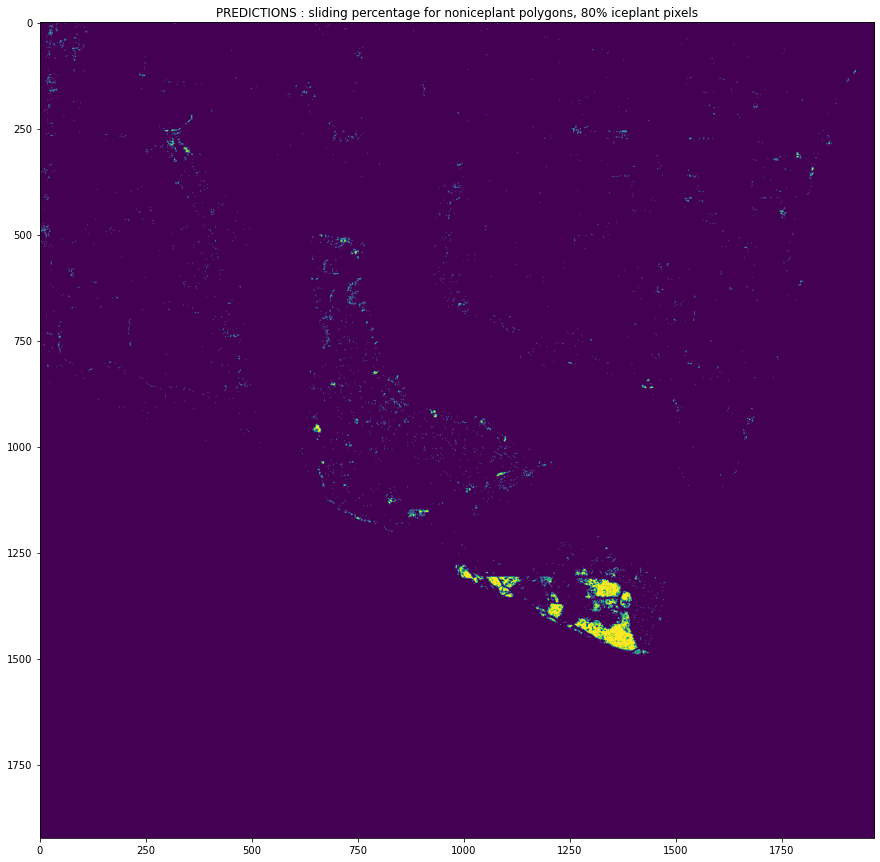

In [115]:
reconstructed = ipf.mask_ndvi_and_predict(cp.itemid, cp.geometry, rfc)

fig, ax = plt.subplots(figsize=(15, 15))
plt.title("PREDICTIONS : sliding percentage for noniceplant polygons, 80% iceplant pixels")
ax.imshow(reconstructed)
plt.show()